### Imports

In [2]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
import numpy
import os

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.afw.math as afwMath


# Firefly client imports
from IPython.display import IFrame

In [3]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

### Set up the config for the ISR task.  This essentially turns off all processing other than overscan and bias correction.

In [4]:
isr_config = IsrTask.ConfigClass()

isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doAddDistortionModel=False
isr_config.doLinearize=False
isr_config.doSaturationInterpolation=False

### Construct the `IsrTask` with the above configuration

In [5]:
isr = IsrTask(config=isr_config)

### Setup firefly to do image visualization

In [6]:
my_channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'


ff='{}/firefly/slate.html?__wsch={}'.format(server, my_channel)
IFrame(ff,800,600)

afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.getDisplay(frame=1, 
                                    name=my_channel)

In [6]:
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)
visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FLAT', 'testType': 'FLAT'})
gain = {}
exp_time = {}
repvalue = {}

i = 1
for visit1, visit2 in zip(visits[:-1:2], visits[1::2]): # loop over pairs of images
    # Get ISR data for first image
    dId = {'visit': visit1, 'detector': 2}
    raw1 = butler.get('raw', **dId)
    bias1 = butler.get('bias', **dId)
    time1 = raw1.getInfo().getVisitInfo().getExposureTime()
    
    # Get ISR data for second image
    dId = {'visit': visit2, 'detector': 2}
    raw2 = butler.get('raw', **dId)
    bias2 = butler.get('bias', **dId)
    time2 = raw2.getInfo().getVisitInfo().getExposureTime()
    if abs(time1 - time2) > 0.01:
        "Mismatched exptimes"
        continue
    
    # run ISR on both images
    result1 = isr.run(raw1, bias=bias1)
    result2 = isr.run(raw2, bias=bias2)
    
    detector = result1.exposure.getDetector()
    amp = detector[3]

    sub_im1 = result1.exposure.getMaskedImage()[amp.getBBox()]
    #arr1 = sub_im1.getImage().getArray()
    sub_im2 = result2.exposure.getMaskedImage()[amp.getBBox()]
    #arr2 = sub_im2.getImage().getArray()
    
    # From RHL, 1/g = <(I1-I2)**2/(I1+I2)>
    diff_im = sub_im1.clone()
    diff_im -= sub_im2
    
    sum_im = sub_im1.clone()
    sum_im += sub_im2
    
    diff_im *= diff_im
    diff_im /= sum_im
    
    stats = afwMath.makeStatistics(diff_im, afwMath.MEDIAN | afwMath.MEAN)
    rep = afwMath.makeStatistics(sum_im, afwMath.MEDIAN | afwMath.MEAN )
    # Compute gain for this amp.
    repvalue[visit1] = rep.getValue(afwMath.MEAN) / 2.
    gain[visit1] = 1/stats.getValue(afwMath.MEAN)
    exp_time[visit1] = time1
    print("visit %i,%i -- %i of %i -- gain=%f, exposure time(s)=%f"%(visit1, visit2, i, len(visits)/2, gain[visit1], exp_time[visit1], ))
    i += 1

visit 258339739,258339769 -- 1 of 39 -- gain=0.505830, exposure time(s)=0.088000
visit 258339807,258339839 -- 2 of 39 -- gain=0.520910, exposure time(s)=0.115000
visit 258339875,258339908 -- 3 of 39 -- gain=0.573624, exposure time(s)=0.160000
visit 258339945,258339976 -- 4 of 39 -- gain=0.597037, exposure time(s)=0.213000
visit 258340014,258340047 -- 5 of 39 -- gain=0.620209, exposure time(s)=0.284000
visit 258340086,258340120 -- 6 of 39 -- gain=0.639889, exposure time(s)=0.498000
visit 258340159,258340176 -- 7 of 39 -- gain=0.649814, exposure time(s)=0.667000
visit 258340202,258340220 -- 8 of 39 -- gain=0.650776, exposure time(s)=0.889000
visit 258340244,258340265 -- 9 of 39 -- gain=0.632029, exposure time(s)=1.156000
visit 258340290,258340314 -- 10 of 39 -- gain=0.665427, exposure time(s)=1.601000
visit 258340341,258340363 -- 11 of 39 -- gain=0.394879, exposure time(s)=2.135000
visit 258340392,258340416 -- 12 of 39 -- gain=0.674312, exposure time(s)=2.847000
visit 258340449,258340477

In [7]:
afw_display.mtv(sub_im1) # display an example image

In [8]:
x = [repvalue[visit] for visit in repvalue.keys()]
y = [gain[visit] for visit in gain.keys()]

[]

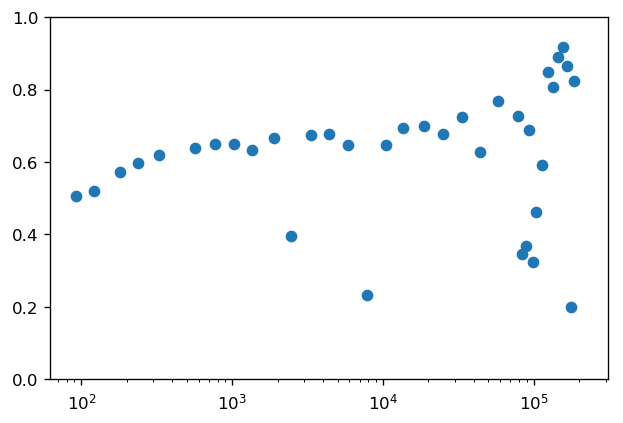

In [9]:
plt.scatter(x, y)
plt.ylim(0, 1)
plt.semilogx()

[]

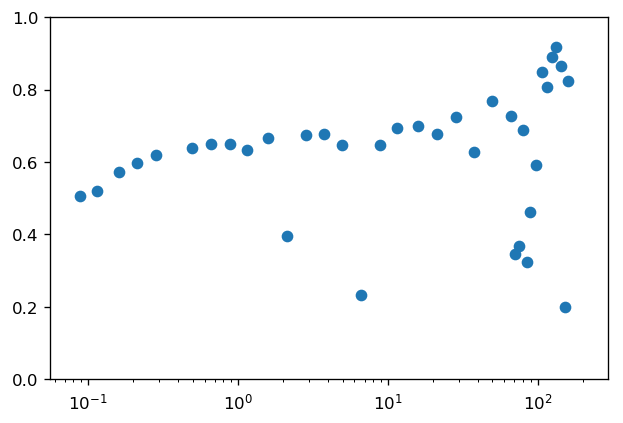

In [10]:
plt.scatter([exp_time[visit] for visit in repvalue.keys()], y)
plt.ylim(0, 1)
plt.semilogx()

In [11]:
amp.getBBox()

Box2I(minimum=Point2I(1536, 0), dimensions=Extent2I(512, 2002))

In [76]:
def rebin(arr, new_shape):
    print(new_shape)
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    print(shape, arr.shape[0] // new_shape[0], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

In [52]:
raw1.getInfo().getMetadata().getScalar("MONDIODE") * raw1.getInfo().getVisitInfo().getExposureTime()
print(raw1.getInfo().getDetector().getName())


R00_S02


In [35]:
arr1 = sub_im1.getImage().getArray()

In [85]:
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)
visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FLAT', 'testType': 'FLAT'})
ogain = {}
gain = {}
mgain = {}
exp_time = {}

i = 1
for visit1, visit2 in zip(visits[:-1:2], visits[1::2]): # loop over pairs of images
    # Get ISR data for first image
    dId = {'visit': visit1, 'detector': 2}
    raw1 = butler.get('raw', **dId)
    bias1 = butler.get('bias', **dId)
    time1 = raw1.getInfo().getVisitInfo().getExposureTime()
    
    # Get ISR data for second image
    dId = {'visit': visit2, 'detector': 2}
    raw2 = butler.get('raw', **dId)
    bias2 = butler.get('bias', **dId)
    time2 = raw2.getInfo().getVisitInfo().getExposureTime()
    if abs(time1 - time2) > 0.01:
        "Mismatched exptimes"
        continue
    
    # run ISR on both images
    result1 = isr.run(raw1, bias=bias1)
    result2 = isr.run(raw2, bias=bias2)
    
    detector = result1.exposure.getDetector()
    amp = detector[3]

    sub_im1 = result1.exposure.getMaskedImage()[amp.getBBox()]
    #arr1 = sub_im1.getImage().getArray()
    sub_im2 = result2.exposure.getMaskedImage()[amp.getBBox()]
    #arr2 = sub_im2.getImage().getArray()
    
    # From RHL, 1/g = <(I1-I2)**2/(I1+I2)>
    diff_im = sub_im1.clone()
    diff_im -= sub_im2
    
    sum_im = sub_im1.clone()
    sum_im += sub_im2
    
    diff_im *= diff_im
    diff_im /= sum_im

    stats = afwMath.makeStatistics(diff_im, afwMath.MEDIAN | afwMath.MEAN)
    diff_im_np = diff_im.getImage().getArray()
    diff_im_binned = rebin(diff_im_np,(int(diff_im_np.shape[0]/2),int(diff_im_np.shape[1]/2)))

    # Compute gain for this amp.

    ogain[visit1] = 1/stats.getValue(afwMath.MEAN)
    gain[visit1] = 1/numpy.mean(diff_im_binned)
    mgain[visit1] = 1/numpy.median(diff_im_binned)
    exp_time[visit1] = time1
    print("visit %i,%i -- %i of %i -- gain=%f, exposure time(s)=%f"%(visit1, visit2, i, len(visits)/2, gain[visit1], exp_time[visit1], ))
    i += 1
    

(1001, 256)
(1001, 2, 256, 2) 2 2
visit 258339739,258339769 -- 1 of 39 -- gain=0.505830, exposure time(s)=0.088000
(1001, 256)
(1001, 2, 256, 2) 2 2
visit 258339807,258339839 -- 2 of 39 -- gain=0.520910, exposure time(s)=0.115000
(1001, 256)
(1001, 2, 256, 2) 2 2
visit 258339875,258339908 -- 3 of 39 -- gain=0.573624, exposure time(s)=0.160000
(1001, 256)
(1001, 2, 256, 2) 2 2
visit 258339945,258339976 -- 4 of 39 -- gain=0.597037, exposure time(s)=0.213000
(1001, 256)
(1001, 2, 256, 2) 2 2
visit 258340014,258340047 -- 5 of 39 -- gain=0.620209, exposure time(s)=0.284000
(1001, 256)
(1001, 2, 256, 2) 2 2
visit 258340086,258340120 -- 6 of 39 -- gain=0.639889, exposure time(s)=0.498000
(1001, 256)
(1001, 2, 256, 2) 2 2
visit 258340159,258340176 -- 7 of 39 -- gain=0.649814, exposure time(s)=0.667000
(1001, 256)
(1001, 2, 256, 2) 2 2
visit 258340202,258340220 -- 8 of 39 -- gain=0.650777, exposure time(s)=0.889000
(1001, 256)
(1001, 2, 256, 2) 2 2
visit 258340244,258340265 -- 9 of 39 -- gain=0

[]

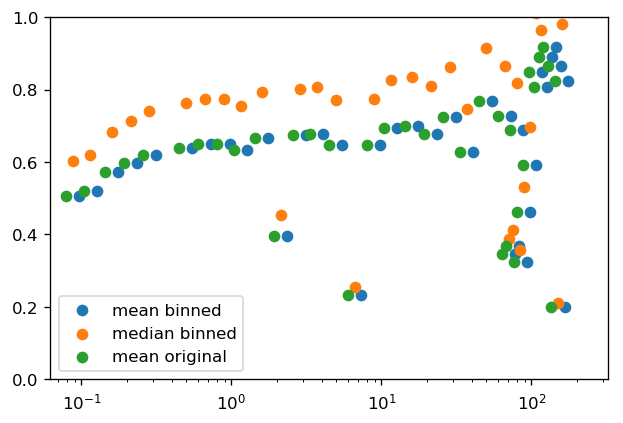

In [41]:
exptime = numpy.array([exp_time[visit] for visit in exp_time.keys()])
plt.scatter(exptime*1.1, [gain[visit] for visit in gain.keys()],label="mean binned")
plt.scatter(exptime, [mgain[visit] for visit in gain.keys()], label="median binned")
plt.scatter(exptime*0.9, [ogain[visit] for visit in gain.keys()],label="mean original")
plt.legend()
plt.ylim(0, 1)
plt.semilogx()

In [43]:
diff_im_binned.shape

(1001, 256)